### Model Fitting 

# Data Processing and Model Selection with SKLearn Pipelines

The effectiveness of a model often depends on the quality of data preprocessing and the choice of the appropriate machine learning algorithm. In this notebook, we'll explore how to leverage SKLearn pipelines to efficiently process data and fit various machine learning models to make an informed selection. 
Our goal is to identify the model that produces the best Weighted Macro F1 Score, a crucial metric for classification tasks.

### The process will involve the following key steps:
1. Data Exploration
2. Data Imputation
3. Data Standardization
4. Model Fitting
5. Performance Evaluation
6. Model Selection

# Step 1: Importing necessary libraries

In [4]:
#Use the below command to install xgboost package incase of having module not found error for `xgboost`
#!pip install xgboost


# Import required packages
#matplotlib package to visualize the data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#To split the data into train and test datasets
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# Step 2: Preprocessing the Data
## Load, Explore and Clean Data

In [5]:
# Load the dataset that was randomly generated in the previous notebook
df = pd.read_csv('data_divas.csv')

In [6]:
# Check the total number of rows and columns
df.shape

(1000, 7)

Check column names, and for convenience, remove whitespaces...

In [7]:
df.columns

Index(['Unnamed: 0', 'feature1', 'feature2', 'feature3', 'feature4',
       'feature5', 'Target'],
      dtype='object')

## Visualize the synthesized data

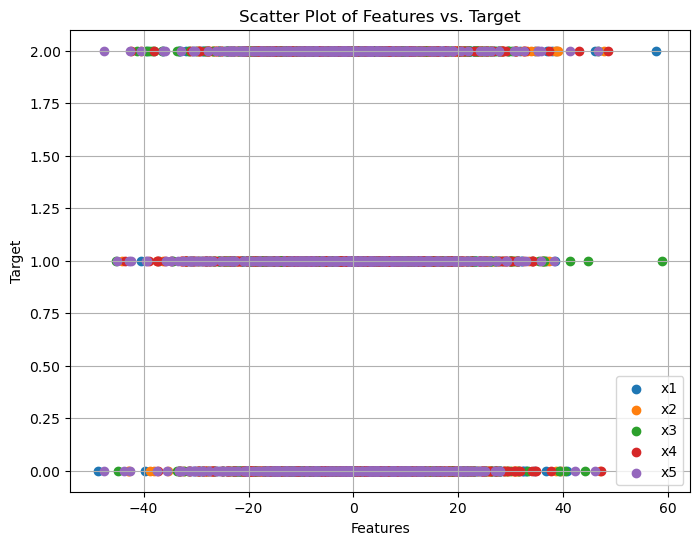

In [8]:
plt.figure(figsize=(8, 6))

y = df['Target']
plt.scatter(df['feature1'], y, label='x1')
plt.scatter(df['feature2'], y, label='x2')
plt.scatter(df['feature3'], y, label='x3')
plt.scatter(df['feature4'], y, label='x4')
plt.scatter(df['feature5'], y, label='x5')

# Set axis labels and a legend
plt.xlabel('Features')
plt.ylabel('Target')
plt.legend()

# Show the plot
plt.title('Scatter Plot of Features vs. Target')
plt.grid(True)
plt.show()

In [9]:
# check for missing values
df.isnull().sum()

Unnamed: 0      0
feature1        0
feature2      100
feature3        0
feature4      100
feature5        0
Target          0
dtype: int64

If the number of missing values in a feature is high (relative to the number of observations), then remove that feature from the dataset. Although we have selected 60% in this instance, the exact percentage of choice will often depend on the dataset and the analysis/problem's context.

In [10]:
#axis=1 is column. thresh=int(0.60*df.shape[0]) means that if a column has less than 60% of the data, it will be dropped
df = df.dropna(axis=1, thresh=int(0.60*df.shape[0])) 

If the number of missing values in a observation (row) is high

In [11]:
# axis=0 is row. thresh=int(0.25*(df.shape[1]-1)) means that if a row has less than 25% of the data, it will be dropped
df = df.dropna(axis=0, thresh=int(0.25*(df.shape[1]-1)))

In [12]:
# Check the datatypes of the columns
df.dtypes

Unnamed: 0      int64
feature1      float64
feature2      float64
feature3      float64
feature4      float64
feature5      float64
Target          int64
dtype: object

As there are no categorical variables, there is no need to convert them into dummy variables(one hot encoding).

## Check for Data Imbalance

1    347
0    340
2    313
Name: Target, dtype: int64


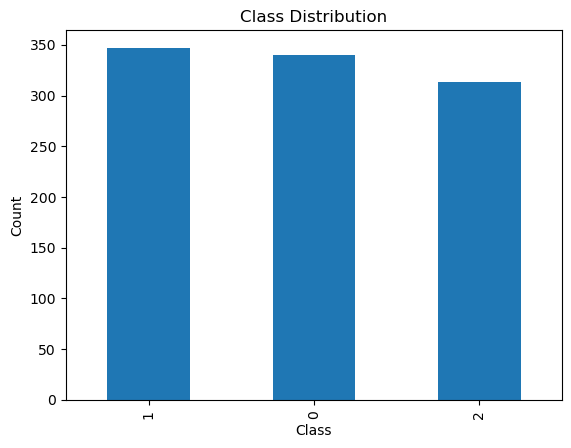

In [16]:
class_distribution = df["Target"].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

    There is a little data imbalance in the dataset as class 2 has relatively lower count values.

# Step 3: Train and Test data split

## Conduct the train-test split before standardizing the data or imputing missing values

The Train-Test Split should be conducted before any data cleaning that is based on calculations of the data. For instance, imputing missing values, and standardizing/normalizing data.


In [10]:
features = df.drop(columns=['Target'])
target = df['Target']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 4: Standardization of data 

In [11]:
# Create transformers for imputation and standardization
numeric_features = features.select_dtypes(include=[np.number]).columns
categorical_features = features.select_dtypes(include=[object]).columns 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

In [12]:
# Create a column transformer to apply the transformers to the appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [13]:
# Create a dictionary of models to evaluate
models = {
    'Neural Network': MLPClassifier(max_iter=10000, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42)
}

# Step 5: Model Fitting

In [14]:
best_model = None
best_f1_score = 0

# Iterate over models and evaluate them
for model_name, model in models.items():
    # Create a pipeline for each model
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit the model on the training data
    model_pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model_pipeline.predict(X_test)

    # Calculate the Weighted Macro F1 Score
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} Weighted Macro F1 Score: {weighted_f1}")

    #Performance evaluation
    if weighted_f1 > best_f1_score:
        best_model = model_name
        best_f1_score = weighted_f1

print(f"The best model is {best_model} with a Weighted Macro F1 Score of {best_f1_score}")


Neural Network Weighted Macro F1 Score: 0.32577410197065676
XGBoost Weighted Macro F1 Score: 0.31275391080623294
RandomForest Weighted Macro F1 Score: 0.2955722842522503
The best model is Neural Network with a Weighted Macro F1 Score of 0.32577410197065676


### Analysis:

From the three models that were tested: Neural Network, XGBoost, and RandomForest, it is evident that the Neural Network emerged as the top performer. The efficiency of these models can be measured by utilizing the Weighted Macro F1 Score, a metric that could evaluate the precision of the model and recall on different classes, by considering the imbalance between classes. In other words, while certain categories may contain fewer instances than others, a higher weighted Macro F1 Score would suggest that the model is doing better at accurately predicting different categories.
### Examining the results:
1. Neural Network: This model obtained the maximum weighted Macro F1 score of around 0.326.
2. RandomForest: It gets an approximate weighted Macro F1 score of 0.296.
3. XGBoost: With a weighted Macro F1 score of around 0.313, it is slightly higher than RandomForest.


### Conclusion:
Neural Network is found to be the best option of these three models; it has performed well at categorizing the synthesized data.
